# FW functions


In [2]:
import sys
# Second append the folder path in name-file.py
sys.path.insert(0, '/home/ejafari/alignment/Git/src')
from utils import *
from FW import *
from evals import *
from collections import Counter




In [ ]:
def find_multi_cells(adata_k, n_clusters):
    
    X = adata_k.to_df().to_numpy()
    kmeans = KMeans(n_clusters, random_state=123).fit(X)
    ################################## find multi-cell clusters #################################
    # find number of occurance for each cluster label
    cluster_df = adata_k.to_df()
    to_be_dropped = []
    counter_dict = Counter(kmeans.labels_)
    for i_label in range(len(kmeans.labels_)):
        
        if counter_dict[i_label] > 1:
#           print(i_label, counter_dict[i_label])

            # Add the multi-cells with their center values in KMeans
            indices = [i for i, x in enumerate(kmeans.labels_) if x == i_label]
            inds = cluster_df.index[indices]
            to_be_dropped.extend(inds)
            
            # new index that contains the name of all cells in the multi-cell
            new_index = '&'.join(inds)
#             print(new_index)
            # Mean value for the multi-cell is exactly the KMeans center
            cluster_df.loc[new_index] = kmeans.cluster_centers_[i_label]
    # drop the cells with frequencies greater than 1
#     print(to_be_dropped)
    cluster_df = cluster_df.drop(to_be_dropped)
    print("After combining multi-cells: ", cluster_df.shape) 
    return cluster_df



def run_fw(X, Y, similarity,   rna_multi_clusters, cluster, n_iter, lambd, ignore=False, show_details=False, verbose=False, gamma='opt'):
    final_P, col_ind_cells, j_p = solve_FW(Y, X, similarity.values, lambd, n_iter, verbose, show_details, gamma)
    ############################# Calculate FOCCTTM score #############################
    fracs1, fracs2, fo = calc_foscttm(rna_multi_clusters[cluster], atac_multi_cells_clusters[col_ind[cluster]], col_ind_cells, similarity, cluster, ignore, show_details)
    if show_details:
        print('-----------------------------------------------------------------------')
    return final_P, col_ind_cells, fo, j_p, fracs1, fracs2



def calc_foscttm(data1, data2, col_ind_cells, similarity, cluster_num, ignore_no_cluster_match=False, show_details=False):
    fracs1 = []
    fracs2 = []
    data1_align_dict = dict()

    
    cells_in_cluster_rna = get_cells_cluster(rna, cluster_num)
    cells_in_cluster_atac = get_cells_cluster(atac_cis_on_org, col_ind[cluster_num])
    
    print('Inside calc_foscttm: ')
    display(atac_cis_on_org.to_df().head())
    print(len(set(cells_in_cluster_rna) & set(cells_in_cluster_atac)))
    print("Check: ", len(cells_in_cluster_rna), len(cells_in_cluster_atac), col_ind[cluster_num])
    
    adata_rna_k = rna[rna.obs.loc[cells_in_cluster_rna].index].to_df() # ALL genes. TODO: explore when using ONLY MARKER genes 
    adata_atac_k = atac_cis_on_org[atac_cis_on_org.obs.loc[cells_in_cluster_atac].index].to_df() # ALL genes. TODO: explore when using ONLY MARKER genes
    print('Inside calc_foscttm, adata_atac_k: ')
    display(adata_atac_k.head())
    
    for i in range(len(col_ind_cells)):
        # If cell name is multi-cell (contains &) then split it 
        cell1_list = similarity.index[i].split('&')  # RNA cell
        cell2_list = similarity.columns[col_ind_cells[i]].split('&') # ATAC cell that's matched to RNA cell check prev code
        data1_align_dict[tuple(cell1_list)] = cell2_list # cell2_list is a list of size 1 if not a multi-cell
    
    
                
    for cell1_list, cell2_list in data1_align_dict.items():
        
        
        for cell1 in cell1_list:
            cell1_fracs = []
            for cell2 in cell2_list:
                ############################## Find distance in data2 (atac) ##############################
                # Cluster level distance
                n_closer = get_n_closer(cell1, cell2, adata_atac_k, cells_in_cluster_atac, show_details)
                if n_closer < 0 and ignore_no_cluster_match == False:
                    # Search the whole global space (global distance)
                    # If the cell does NOT have a true alignment in the aligned cluster
                    #Calculate distance of the node to all other cells GLOBALLLY
                    n_closer = get_n_closer(cell1, cell2, atac_cis_on_org.to_df(), atac_cis_on_org.to_df().index, show_details)
                
                # This makes sure not to include a cell if it doesn't exist in both domains
                if n_closer >= 0:
                    cell1_fracs.append(n_closer)
                
            # Mean fracs when multi-cells if correspondence exists
            if len(cell1_fracs) > 0:
                fracs1.append(np.mean(cell1_fracs))
#                 print("cell1_fracs: ", cell1_fracs)
#                 print(fracs1)

        # Find distance in data 1 (RNA)
        for cell2 in cell2_list:
            cell2_fracs = []
            for cell1 in cell1_list:
                ############################## Find distance in data1 (rna) ##############################
                # Cluster level distance
                n_closer = get_n_closer(cell2, cell1, adata_rna_k, cells_in_cluster_rna, show_details)
                if n_closer < 0 and ignore_no_cluster_match == False:
                    # Search the whole global space (global distance)
                    # If the cell does NOT have a true alignment in the aligned cluster
                    #Calculate distance of the node to all other cells GLOBALLLY
                    n_closer = get_n_closer(cell2, cell1, rna.to_df(), rna.to_df().index, show_details)
                if n_closer >= 0:
                    cell2_fracs.append(n_closer)
            # Mean fracs when multi-cells if correspondence exists
            if len(cell2_fracs) > 0:
                fracs2.append(np.mean(cell2_fracs))



    frac1_mean = np.mean(fracs1) / (len(rna) - 1)
    frac2_mean = np.mean(fracs2) / (len(atac_cis_on_org) - 1)
    
    fosccttm = np.mean([frac1_mean, frac2_mean])
    print(len(adata_rna_k), len(adata_atac_k), len(fracs1), frac1_mean, len(fracs2), frac2_mean, fosccttm)
    return fracs1, fracs2, fosccttm




In [2]:
# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster2(adata_r, adata_a, markers_r, markers_a, min_cells=150, rm_correspondence=True):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                adata_a = rm_cls(adata_a, col_ind[int(cls)])
                print("R1: ", cls, col_ind[int(cls)])
            else:
                try:
                    markers_r.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                    print("RNA:", cls)
                except:
                    print("RNA removed already:", cls)
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                cls_r = list(col_ind).index(int(cls))
                adata_r = rm_cls(adata_r, cls_r)
                print("R2: ", cls_r, cls)
            else:
                markers_a.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                print("ATAC:", cls)
    return adata_r, adata_a, markers_r, markers_a


# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster(adata_r, adata_a, min_cells=150):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            adata_a = rm_cls(adata_a, col_ind[int(cls)])
            print("R1: ", cls, col_ind[int(cls)])
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            adata_r = rm_cls(adata_r, list(col_ind).index(int(cls)))
            print("R2: ", list(col_ind).index(int(cls)), cls)
    
    return adata_r, adata_a

def rm_cls(adata, cls):
    '''
     Removes the  cells that belong to cluster cls
    '''
    cls = str(cls)
    # Get the list of cells in the cluster
    dropped_cells = adata.obs[adata.obs['leiden'] == cls].index
    drop_list = adata.to_df().index.isin(dropped_cells)
    # Remove the cluster that is smaller than min_cells
    adata = adata[~drop_list, :]
    return adata

In [3]:
# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster2(adata_r, adata_a, markers_r, markers_a, min_cells=150, rm_correspondence=True):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                adata_a = rm_cls(adata_a, col_ind[int(cls)])
                print("R1: ", cls, col_ind[int(cls)])
            else:
                try:
                    markers_r.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                    print("RNA:", cls)
                except:
                    print("RNA removed already:", cls)
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                cls_r = list(col_ind).index(int(cls))
                adata_r = rm_cls(adata_r, cls_r)
                print("R2: ", cls_r, cls)
            else:
                markers_a.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                print("ATAC:", cls)
    return adata_r, adata_a, markers_r, markers_a


# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster(adata_r, adata_a, min_cells=150):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            adata_a = rm_cls(adata_a, col_ind[int(cls)])
            print("R1: ", cls, col_ind[int(cls)])
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            adata_r = rm_cls(adata_r, list(col_ind).index(int(cls)))
            print("R2: ", list(col_ind).index(int(cls)), cls)
    
    return adata_r, adata_a

def rm_cls(adata, cls):
    '''
     Removes the  cells that belong to cluster cls
    '''
    cls = str(cls)
    # Get the list of cells in the cluster
    dropped_cells = adata.obs[adata.obs['leiden'] == cls].index
    drop_list = adata.to_df().index.isin(dropped_cells)
    # Remove the cluster that is smaller than min_cells
    adata = adata[~drop_list, :]
    return adata

In [5]:
def match_clusters3(markers_rna, markers_ATAC, method="dot", show=True, normal=False, norm_m='l1', verbose =True, threshold=1, top_100=False, disp_res=False):
#     print("Here", method)

    cols_float = []
    for i in range(len(markers_rna.columns) // 3):
        cols_float.append(str(i) + "_l")
    markers_rna[cols_float] = markers_rna[cols_float].astype(float) 
    cols_float = []
    for i in range(len(markers_ATAC.columns) // 3):
        cols_float.append(str(i) + "_l")
    markers_ATAC[cols_float] = markers_ATAC[cols_float].astype(float) 

    res_index = [str(s) + '_rna' for s in list(range(len(markers_rna.columns) // 3))]
    res_col = [str(s) + '_atac' for s in list(range(len(markers_ATAC.columns) // 3))]
    res = pd.DataFrame(index = res_index, columns = res_col)
    res_count = pd.DataFrame(index = res_index, columns = res_col)
    p_val = pd.DataFrame(index = res_index, columns = res_col)

    common_markers_dfs = dict()

    # For all clusters in scRNA
    for col in range(len(markers_rna.columns) // 3): 
        df_rna = markers_rna[[str(col) + "_n", str(col)+ "_s", str(col)+"_l"]].dropna().set_index(str(col) + "_n")
        # For all clusters in ATAC
        for col2 in range(len(markers_ATAC.columns) // 3):
            df_atac = markers_ATAC[[str(col2) + "_n", str(col2)+ "_s", str(col2)+"_l"]].dropna().set_index(str(col2) + "_n")
            # Number of cells in RNA data having logFC above the threshold
            len_rna_g_thr = (df_rna[df_rna.columns[-1]] >= threshold).sum()
            len_atac_g_thr = (df_atac[df_atac.columns[-1]] >= threshold).sum()
            if verbose:
                print("Number of marker genes with values greater than thr in ATAC and RNA: " , len_atac_g_thr, len_rna_g_thr)
            df3 = pd.merge(df_rna, df_atac, left_index=True, right_index=True)
            
            if verbose == True:
                print(col, col2, " shared marker genes no thr:", len(df3), "ATAC & RNA markers \wo thr:", df_atac.shape, df_rna.shape)
#                 display(df3)

                
                
                plt.figure(figsize=(18,8))
                plt.plot(np.array(df3[df3.columns[1]]), '.', markersize=8, color="red", alpha=0.6)
                plt.plot(np.array(df3[df3.columns[3]]), '.', markersize=8, color="blue", alpha=0.6)
                plt.ylabel('LogFC')
                plt.title('RNA and ATAC : ' + str(col) + ', ' + str(col2))
                plt.axhline(y=threshold, color='grey', linestyle='-')
                
                plt.show()
                
            # Find the marker genes that are greater than one in both RNA and ATAC cluster pair that we are cpmparing
            df3_greater_1 = df3[(df3[df3.columns[-1]] >= threshold) & (df3[df3.columns[1]] >= threshold)]
            

            
            
            if verbose == True:
                print("df3_greater_than_threshold size: ", df3_greater_1.shape)
            # sum up the logFC values of the RNA in the df3_greater_1
            vector_rna = df3_greater_1[df3_greater_1.columns[1]]
            vector_atac = df3_greater_1[df3_greater_1.columns[3]]
            

            if method == 'simSIP':
#                 print(method)
                rank_rna = get_ranking(df3_greater_1[df3_greater_1.columns[1]])
                rank_atac = get_ranking(df3_greater_1[df3_greater_1.columns[3]])
#                 print("RNA: ", rank_rna)
#                 print(rank_atac)
                # sum of geometrical mean
                simSIP = np.sum(np.sqrt(1/ (rank_rna * rank_atac)))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = simSIP
            
            if method == 'rank_rna_shared':
#                 display(df3_greater_1)
#                 display(df_rna)

                marker_list = df_rna.index.isin(df3_greater_1.index)
                indecies_in_rna = np.where(marker_list)[0]
#                 print(type(indecies_in_rna))
                if top_100:
                    indecies_in_rna = np.asarray([i for i in indecies_in_rna if i <= 100])
#                 print(col, col2)
#                 print(indecies_in_rna)
#                 print(type(indecies_in_rna))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = np.sum(np.sqrt(1 / (indecies_in_rna + 1)))

                
            if len(df3_greater_1) != 0 and normal == True:
                 try:
                    vector_rna = normalize(vector_rna.to_numpy().reshape(1, -1), norm=norm_m, axis=1)
                    vector_atac = normalize(vector_atac.to_numpy().reshape(1, -1), norm=norm_m, axis=1)
#                     print(vector_rna, vector_atac)
                 except ValueError:
                    # If size of the vectors is 0
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = 0
            
            if len(df3_greater_1) == 0:
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = 0
            elif method == "dot":
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = np.dot(vector_rna, vector_atac.T)
            elif method == 'cosine':
                try:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = cosine_similarity(vector_rna.to_numpy().reshape(1, -1), vector_atac.to_numpy().reshape(1, -1))
                except AttributeError:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = cosine_similarity(vector_rna.reshape(1, -1), vector_atac.reshape(1, -1))
                
            elif method == 'corr':
#                 print(np.corrcoef(vector_rna.to_numpy().reshape(1, -1), vector_atac.to_numpy().reshape(1, -1)))
                if len(vector_rna) < 2:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = 0
                else:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = np.corrcoef(vector_rna.to_numpy().reshape(1, -1), vector_atac.to_numpy().reshape(1, -1))[0][1]
                
            elif method == 'count' or method == 'rank_rna_shared':
                res_count.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna)
                
                n_shared_list = []
                n = 200
                for iterr in range(n):
                    # Random sample of size: Number of cells in RNA having logFC above the threshold
                    sample_rna = df_rna.sample(len_rna_g_thr)
                    # Random sample of size: Number of cells in ATAC having logFC above the threshold
                    sample_atac = df_atac.sample(len_atac_g_thr)
#                     print("P-value: ", len(set(sample_rna.index) & set(sample_atac.index)))
                    n_shared_list.append(len(set(sample_rna.index) & set(sample_atac.index)))
                # Find how many times elements in n_share_list are >= res using count for that entry
                p_val.loc[str(col)+'_rna', str(col2)+'_atac'] = sum(i > res_count.loc[str(col)+'_rna', str(col2)+'_atac'] for i in n_shared_list) / n
            
            
                
 
        
        
            elif method == 'proportion':
                # Intersect of genes above the threshold
                union_markers = set(df_atac.index) & set(df_rna.index)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Prop: ", len(vector_rna), len(union_markers))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / len(union_markers)
                
            elif method == 'prop_intersect':
                # shared markers
                all_markers = len(df3)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Jaccard thr: ", len(vector_rna), all_markers)
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / all_markers
                
                
            elif method == 'prop_union':
                # union of markers
                union_markers = set(df_atac.index) | set(df_rna.index)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Jaccard thr: ", len(vector_rna), len(union_markers))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / len(union_markers)
                
            elif method == 'jaccard_thr':
                # union of markers above the threshold
                df_atac = df_atac[df_atac[df_atac.columns[-1]] >= threshold]
                df_rna = df_rna[df_rna[df_rna.columns[-1]] >= threshold]
                union_markers = set(df_atac.index) | set(df_rna.index)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Jaccard thr: ", len(vector_rna), len(union_markers))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / len(union_markers)
                


    if disp_res == True:           
        display(res)
    print("P-values:") 
    display(p_val)


    ################################## Linear assignment ##############################################
    from scipy.optimize import linear_sum_assignment
    
    try:
        cost = res.to_numpy(dtype='float') * -1
        row_ind, col_ind = linear_sum_assignment(cost)
        
        #cost = cost*-1
#         print(col_ind)
#         print(cost[row_ind, col_ind].sum())
        return col_ind, res
    except:
        return 0

# RNA and ATAC

AnnData object with n_obs × n_vars = 19322 × 5081
AnnData object with n_obs × n_vars = 5081 × 19322
5081
19322


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 5081 × 15028
    obs: 'n_genes'
    var: 'n_cells'
5081
15028
View of AnnData object with n_obs × n_vars = 5081 × 15028
    obs: 'n_genes'
    var: 'n_cells'


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 5081 × 3724
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


/home/ejafari/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


         Falling back to preprocessing with `sc.pp.pca` and default params.


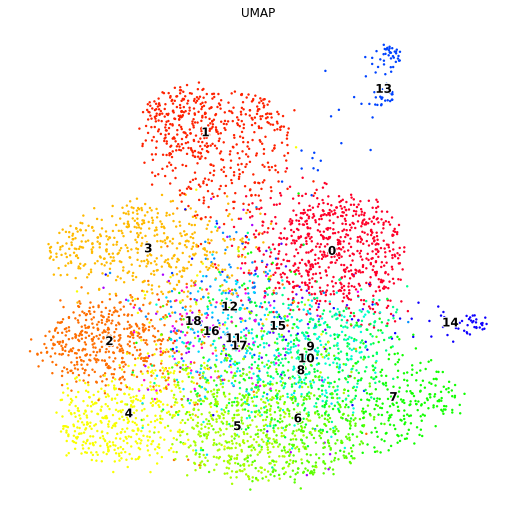

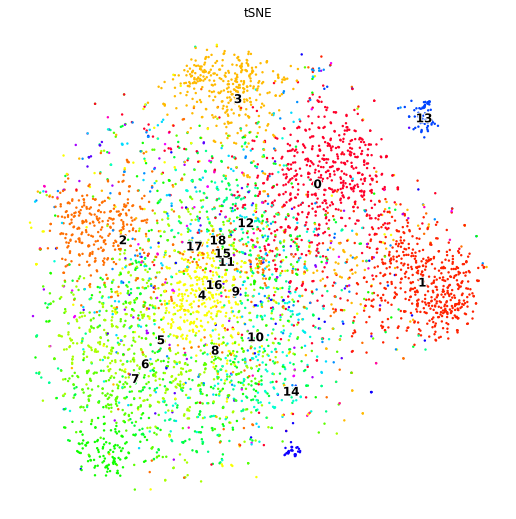

0 : 703
1 : 562
2 : 495
3 : 491
4 : 476
5 : 460
6 : 432
7 : 279
8 : 220
9 : 216
10 : 192
11 : 137
12 : 97
13 : 91
14 : 64
15 : 52
16 : 43
17 : 39
18 : 32


In [3]:
############################ High_var = True ######################################
input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/5k/"
scRNAseq_adrs = input_dir + 'scRNAseq.csv'
# Find marker genes of scRNAseq data
markers_rna, rna = scRNAseq_clustering_original(scRNAseq_adrs, filtering=True, resl=1.62, highly_var=True, mus=False)


AnnData object with n_obs × n_vars = 9 × 5081
AnnData object with n_obs × n_vars = 5081 × 9


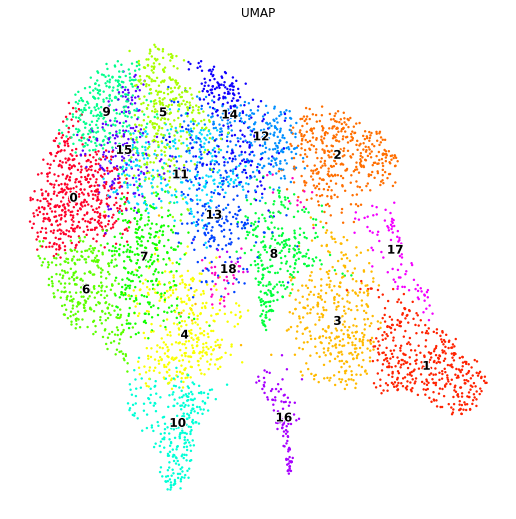

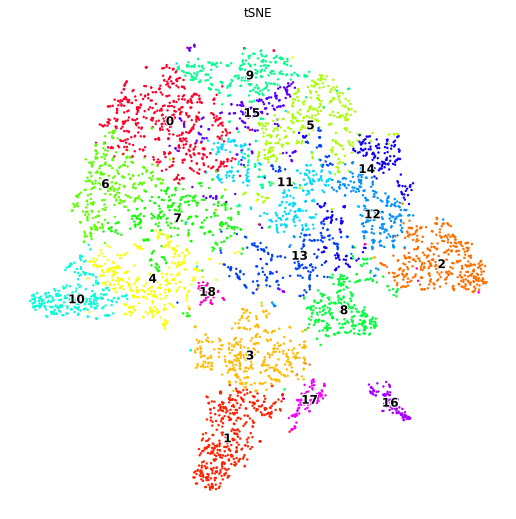

0 : 499
1 : 405
2 : 377
3 : 368
4 : 338
5 : 334
6 : 293
7 : 291
8 : 286
9 : 278
10 : 259
11 : 257
12 : 234
13 : 232
14 : 214
15 : 177
16 : 109
17 : 85
18 : 45


In [7]:
# Find clusters of low dimensional cisTopic result for scATACseq

atac = clustering(input_dir + 'cisTopic_topics.tsv', transpose=True, resl=1.55)

############################ scATAC ######################################
# 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
f_original = 'pred_matrix_closest_genes_1k_downstream_strand_first_prom.csv'
markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)




In [8]:
# sc.pl.umap(atac_cis_on_org, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='UMAP ATACseq', palette='gist_rainbow', save='UMAP_ATAC_5k_all.svg')#
# sc.pl.umap(rna, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='UMAP RNAseq', palette='gist_rainbow', save='UMAP_RNA_5k_all.svg')#

## Min_cells: 200

In [9]:
rna, atac_cis_on_org,  markers_rna, markers_atac = rm_small_cluster2(rna, atac_cis_on_org,markers_rna, markers_atac, min_cells=200, rm_correspondence=False)

/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


RNA: 11
RNA: 13
RNA: 12
RNA: 17
RNA: 16
RNA: 18
RNA: 15
RNA: 10
RNA: 14
ATAC: 17
ATAC: 16
ATAC: 15
ATAC: 18


In [10]:
# Checkpoint

pd.set_option('display.max_columns', 30)
n, m = len(set(rna.obs['leiden'])), len(set(atac_cis_on_org.obs['leiden']))
df_aggr = pd.DataFrame(np.zeros((n,m)), columns=np.arange(0,m), index=np.arange(0,n))
for my_threshold in np.arange(0.0, 1.0, 0.1):
#     print(my_threshold)
    col_ind, res = match_clusters3(markers_rna, markers_atac, method="rank_rna_shared", verbose=False, threshold=my_threshold, top_100=True, disp_res=True)
    print(my_threshold.round(1), col_ind)
    print('$$$-------------------------------------------------------------------$$$')
    for i in range(len(col_ind)):
        df_aggr.iat[i, col_ind[i]] = df_aggr.iat[i, col_ind[i]] + 1
        
display(df_aggr)

# Linear Assignment to get final col_ind (cluster alignment)
cost = df_aggr.to_numpy(dtype='float') * -1
row_ind, col_ind = linear_sum_assignment(cost)
print(col_ind)

,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,2.07171,1.36603,4.38501,1.81324,0.377964,2.94659,1.17813,0.769886,2.75663,3.12105,0.377964,4.56195,4.41256,1.57286,3.65497
1_rna,1.48267,7.82253,2.89688,7.98065,1.08274,2.96521,1.3192,1.01524,2.74866,2.06498,0.781226,1.24557,1.60476,2.44715,1.92372
2_rna,2.55326,1.00877,1.36793,1.00877,1.65155,2.34895,2.88968,2.99227,1.9261,2.62445,1.61977,2.77521,2.2091,2.19176,2.17
3_rna,0,2.78199,4.99345,1.37375,1.14956,1.22691,0.316228,0.649561,4.99345,0.57735,1.14956,1.52456,2.6197,4.54623,4.64303
4_rna,1.96965,2.48336,1.19816,2.48336,4.74713,2.32077,5.06172,4.98729,3.03788,1.72267,4.62509,1.73077,1.1891,3.52504,2.25758
5_rna,4.3357,2.64707,0.802246,1.64707,0.538675,2.91221,4.3357,3.48732,1.33767,3.60345,0.538675,4.21896,1.11847,0.918045,1.69263
6_rna,2.44371,0.447214,0.707107,0.447214,1.02456,3.15082,2.09016,2.89093,1.06066,3.15082,1.02456,1.59016,0.707107,1.56066,1.89399
7_rna,2.40678,0.866025,0.70976,0.866025,1.18225,2.27771,1.69968,1.98835,1.30183,2.81503,0.866025,2.72301,1.73309,1.22448,2.57771
8_rna,2.15432,0.5,0,0.5,0,2.65432,1,1.44721,0.447214,2.65432,0,0.707107,0.707107,1.44721,2.65432
9_rna,2.78446,0,0,0,1,1.78446,1.70711,2.20711,0.5,2.78446,1,2.28446,0.57735,0.5,1.07735


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0.195,0.875,0,0.7,0.86,0.085,0.365,0.645,0.52,0,0.81,0.005,0,0.625,0.035
1_rna,0.97,0,0.32,0,0.865,0.77,0.93,1,0.745,0.805,0.895,0.99,0.7,0.86,0.97
2_rna,0.06,0.985,0.59,0.995,0.275,0.295,0.01,0.02,0.8,0.08,0.165,0.055,0.06,0.375,0.4
3_rna,NaN,0.36,0,0.61,0.225,0.89,0.915,0.59,0,0.975,0.215,0.685,0.01,0,0
4_rna,0.445,0.545,0.935,0.595,0,0.895,0,0,0.465,0.75,0,0.625,0.955,0.315,0.815
5_rna,0.005,0.54,0.835,0.72,0.785,0.505,0,0.085,0.94,0.105,0.755,0.01,0.79,0.9,0.755
6_rna,0,0.955,0.865,0.92,0.295,0.01,0,0,0.865,0.01,0.255,0.105,0.645,0.195,0.12
7_rna,0.06,0.915,0.76,0.915,0.195,0.03,0.035,0.005,0.9,0.04,0.435,0.02,0.545,0.36,0.08
8_rna,0.035,0.645,NaN,0.57,NaN,0,0.095,0.055,0.715,0,NaN,0.505,0.3,0.17,0
9_rna,0,NaN,NaN,NaN,0.185,0.095,0,0,0.65,0,0.2,0.04,0.555,0.83,0.4


0.0 [12  3  7  2  6  0  5 11 14  9]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,1.49436,1.36603,3.8538,1.07735,0,2.19787,0.52735,0.52735,2.25663,1.38762,0.377964,2.74055,3.79206,0.982675,3.37762
1_rna,0.887455,7.63996,2.11238,7.40426,0.601621,1.70079,1.01769,0.699008,1.89379,1.22814,0.601621,0.778308,0.528308,1.11784,1.29521
2_rna,2.30326,1.00877,1.15473,0.790551,1.40155,2.10641,2.39881,1.79853,1.68356,2.41125,1.40155,1.58649,1.1068,1.34117,1.57847
3_rna,0,1.37375,3.99347,1.37375,1.14956,0.316228,0.316228,0.316228,3.96888,0,0.816228,1.02456,1.52456,3.46888,2.93593
4_rna,1.46965,1.77625,0.930904,0.951072,4.24713,1.16645,3.94636,2.93557,1.59066,1.45541,4.24713,0.903425,1.1891,0.25,1.19692
5_rna,3.92745,1.33084,0.802246,0.922589,0.538675,2.2051,3.63878,2.07907,0.650784,3.36774,0.538675,2.3367,0.816962,0.918045,1.69263
6_rna,2.09016,0.447214,0,0.447214,1.02456,2.79727,1.51281,1.4884,1.06066,2.79727,1.02456,0.679476,0.707107,1.56066,1.56066
7_rna,1.69968,0.288675,0,0.288675,0.866025,2.27771,1.39816,1.12081,0.724476,2.10792,0.866025,1.1309,0.724476,0.724476,1.73309
8_rna,1,0.5,0,0.5,0,2.20711,1,1.44721,0.447214,1,0,0,0,1.44721,2.65432
9_rna,1.70711,0,0,0,1,1.28446,1.70711,2.20711,0.5,1.70711,1,1.70711,0,0.5,1.07735


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0.085,0.79,0.005,0.825,NaN,0.06,0.61,0.475,0.435,0.06,0.73,0.005,0,0.51,0
1_rna,0.94,0,0.42,0,0.795,0.86,0.8,0.925,0.83,0.88,0.925,0.865,0.865,0.875,0.945
2_rna,0.005,0.94,0.43,0.975,0.11,0.08,0.015,0.085,0.575,0.025,0.185,0.08,0.18,0.45,0.405
3_rna,NaN,0.65,0.005,0.36,0.055,0.92,0.75,0.535,0,NaN,0.315,0.505,0.145,0.005,0.01
4_rna,0.17,0.59,0.825,0.85,0,0.8,0,0.02,0.43,0.55,0,0.425,0.525,0.975,0.82
5_rna,0,0.73,0.65,0.69,0.565,0.16,0,0.03,0.97,0.04,0.57,0.04,0.52,0.52,0.295
6_rna,0,0.885,NaN,0.8,0.185,0,0.01,0.02,0.67,0.005,0.125,0.2,0.265,0.015,0.17
7_rna,0.005,0.96,NaN,0.93,0.17,0,0.035,0.075,0.855,0.025,0.305,0.23,0.505,0.265,0.295
8_rna,0.325,0.54,NaN,0.405,NaN,0.01,0.065,0.02,0.495,0.48,NaN,NaN,NaN,0.055,0
9_rna,0.06,NaN,NaN,NaN,0.085,0.11,0,0,0.525,0.14,0.18,0.095,NaN,0.41,0.175


0.1 [ 2  1  6  8  4  0  9  5 14  7]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0.52735,1.36603,3.12228,0.57735,0,0.669781,0.52735,0.27735,1.2582,0.593578,0,0.707107,3.06758,0,1.61175
1_rna,0.424078,7.40426,1.59006,6.06594,0.397497,0,0.821574,0.397497,1.49997,0.471385,0.397497,0.370194,0.528308,0.78677,0.493004
2_rna,1.54411,0.790551,1.15473,0.57735,1.17794,0.871644,2.12146,0.45392,1.06275,1.00618,1.40155,0.301511,0.87738,0.5,1.0755
3_rna,0,1.37375,2.28637,1.08507,0.316228,0,0,0.316228,3.96888,0,0.816228,0.447214,1.52456,3.09092,1.43281
4_rna,1.46965,1.39829,0.930904,0.951072,3.54002,0.258199,2.54479,1.66664,0.353553,0.258199,4.24713,0.258199,0.353553,0,0.5
5_rna,3.07001,1.33084,0.802246,0.686887,0.25,0.267261,3.07001,1.1047,0.650784,2.11774,0.538675,0.835549,0.500735,0,1.06173
6_rna,1.01281,0.447214,0,0.447214,0.57735,1.58507,1.01281,0.333333,0.353553,1.78865,1.02456,0,0,0.353553,1.56066
7_rna,1.39816,0.288675,0,0.288675,0,1.39271,1.39816,1.12081,0.316228,0.544611,0.288675,0.5,0,0,1.43158
8_rna,0,0.5,0,0,0,1.70711,0,0,0.447214,1,0,0,0,0.447214,2.65432
9_rna,1.70711,0,0,0,1,0.57735,1.70711,1,0.5,0,1,0,0,0.5,1.07735


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0.255,0.69,0.015,0.875,NaN,0.295,0.42,0.395,0.715,0.15,NaN,0.39,0,NaN,0.1
1_rna,0.79,0,0.32,0,0.685,NaN,0.7,0.615,0.68,0.88,0.88,0.56,0.265,0.42,0.925
2_rna,0.025,0.98,0.185,0.94,0.09,0.21,0.005,0.22,0.605,0.04,0.035,0.475,0.05,0.46,0.195
3_rna,NaN,0.5,0.015,0.365,0.285,NaN,NaN,0.21,0,NaN,0.175,0.325,0.015,0,0.09
4_rna,0.02,0.55,0.61,0.49,0,0.6,0,0.075,0.925,0.685,0,0.375,0.515,NaN,0.805
5_rna,0,0.555,0.305,0.765,0.56,0.67,0.005,0.05,0.78,0.01,0.395,0.165,0.22,NaN,0.165
6_rna,0,0.815,NaN,0.6,0.185,0.005,0.025,0.255,0.67,0.005,0.11,NaN,NaN,0.14,0.015
7_rna,0.035,0.93,NaN,0.82,NaN,0.015,0.01,0,0.805,0.26,0.485,0.295,NaN,NaN,0.095
8_rna,NaN,0.41,NaN,NaN,NaN,0.01,NaN,NaN,0.31,0.145,NaN,NaN,NaN,0.06,0
9_rna,0,NaN,NaN,NaN,0.02,0.055,0,0.045,0.31,NaN,0.175,NaN,NaN,0.075,0.025


0.2 [ 2  1  6  8 10  0  9  5 14  4]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0.52735,1.07735,2.56257,0.57735,0,0,0.27735,0,0.258199,0.316228,0,0.707107,1.15432,0,0
1_rna,0,7.04788,0.812429,5.83653,0.397497,0,0.647497,0,0.953437,0,0.397497,0,0.158114,0,0
2_rna,1.04411,0.790551,0.87738,0,0.57735,0,0.755431,0,0.562749,0.288675,1.17794,0.301511,0.242536,0,0.596089
3_rna,0,1.37375,1.93281,0.377964,0.316228,0,0,0,3.96888,0,0.316228,0.447214,0.947214,1.46891,0
4_rna,0.636163,0.951072,0.353553,0.617739,2.47671,0.258199,1.37796,1,0.353553,0.258199,3.54002,0,0,0,0
5_rna,3.07001,0.686887,0.258199,0.686887,0,0,2.07001,0.82735,0.650784,0.57735,0.25,0.835549,0,0,0.267261
6_rna,1.01281,0.447214,0,0,0,0,0.333333,0,0.353553,0.377964,0.447214,0,0,0,1.20711
7_rna,1.39816,0.288675,0,0,0,0,1.12081,0,0.316228,0.27735,0.288675,0,0,0,0.408248
8_rna,0,0,0,0,0,0,0,0,0.447214,0,0,0,0,0,1
9_rna,1.70711,0,0,0,0,0,1,1,0.5,0,1,0,0,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0.07,0.77,0.055,0.69,NaN,NaN,0.435,NaN,0.715,0.15,NaN,0.055,0.035,NaN,NaN
1_rna,NaN,0,0.49,0,0.38,NaN,0.45,NaN,0.7,NaN,0.715,NaN,0.485,NaN,NaN
2_rna,0.02,0.905,0.18,NaN,0.315,NaN,0.125,NaN,0.53,0.255,0.12,0.15,0.22,NaN,0.06
3_rna,NaN,0.33,0.01,0.535,0.12,NaN,NaN,NaN,0,NaN,0.315,0.065,0.02,0.005,NaN
4_rna,0.125,0.665,0.68,0.595,0,0.02,0.23,0.28,0.71,0.22,0,NaN,NaN,NaN,NaN
5_rna,0,0.8,0.65,0.565,NaN,NaN,0.01,0.05,0.485,0.19,0.525,0.025,NaN,NaN,0.2
6_rna,0.005,0.715,NaN,NaN,NaN,NaN,0.205,NaN,0.445,0.095,0.21,NaN,NaN,NaN,0.005
7_rna,0,0.825,NaN,NaN,NaN,NaN,0.015,NaN,0.59,0.095,0.355,NaN,NaN,NaN,0.055
8_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145,NaN,NaN,NaN,NaN,NaN,0.02
9_rna,0.005,NaN,NaN,NaN,NaN,NaN,0.02,0.02,0.145,NaN,0.05,NaN,NaN,NaN,NaN


0.3 [ 2  1  4  8 10  0  9  6 14  7]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0,0.57735,2.15432,0.57735,0,0,0,0,0,0,0,0,0.707107,0,0
1_rna,0,6.23498,0.812429,5.83653,0.397497,0,0.397497,0,0.953437,0,0.397497,0,0,0,0
2_rna,0.301511,0.57735,0.87738,0,0.57735,0,0.519729,0,0.333333,0,0.910684,0.301511,0.242536,0,0.353553
3_rna,0,1.37375,0.947214,0.377964,0,0,0,0,3.46888,0,0.316228,0,0.447214,0.761802,0
4_rna,0,0.951072,0.353553,0.617739,1.28868,0,1.37796,1,0.353553,0.258199,3.13177,0,0,0,0
5_rna,1.53446,0.686887,0.258199,0.353553,0,0,0.82735,0,0,0,0.25,0,0,0,0
6_rna,0,0.447214,0,0,0,0,0,0,0,0,0,0,0,0,0.707107
7_rna,0.853553,0.288675,0,0,0,0,0.853553,0,0.316228,0,0,0,0,0,0.408248
8_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9_rna,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,NaN,0.91,0.05,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN
1_rna,NaN,0,0.295,0,0.265,NaN,0.525,NaN,0.305,NaN,0.6,NaN,NaN,NaN,NaN
2_rna,0.195,0.97,0.135,NaN,0.225,NaN,0.175,NaN,0.59,NaN,0.185,0.015,0.11,NaN,0.015
3_rna,NaN,0.28,0.13,0.39,NaN,NaN,NaN,NaN,0,NaN,0.23,NaN,0.055,0,NaN
4_rna,NaN,0.565,0.555,0.315,0.025,NaN,0.065,0.11,0.495,0.04,0,NaN,NaN,NaN,NaN
5_rna,0,0.81,0.485,0.665,NaN,NaN,0.195,NaN,NaN,NaN,0.425,NaN,NaN,NaN,NaN
6_rna,NaN,0.665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7_rna,0.025,0.8,NaN,NaN,NaN,NaN,0.02,NaN,0.335,NaN,NaN,NaN,NaN,NaN,0
8_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9_rna,0.025,NaN,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN


0.4 [ 2  1  4  8 10  0 14  5  3  6]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0,0.57735,2.15432,0,0,0,0,0,0,0,0,0,0.707107,0,0
1_rna,0,6.06594,0.35423,5.11631,0.188982,0,0,0,0.335698,0,0.397497,0,0,0,0
2_rna,0,0,0.87738,0,0.57735,0,0.519729,0,0,0,0.57735,0,0,0,0
3_rna,0,1.08507,0.947214,0,0,0,0,0,3.46888,0,0,0,0.447214,0,0
4_rna,0,0.951072,0.353553,0.316228,1,0,0.377964,0,0,0,2.77822,0,0,0,0
5_rna,0.57735,0.686887,0.258199,0,0,0,0.82735,0,0,0,0.25,0,0,0,0
6_rna,0,0.447214,0,0,0,0,0,0,0,0,0,0,0,0,0
7_rna,0,0.288675,0,0,0,0,0.853553,0,0,0,0,0,0,0,0
8_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9_rna,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,NaN,0.775,0.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,NaN,NaN
1_rna,NaN,0,0.59,0,0.365,NaN,NaN,NaN,0.395,NaN,0.505,NaN,NaN,NaN,NaN
2_rna,NaN,NaN,0.045,NaN,0.17,NaN,0.1,NaN,NaN,NaN,0.385,NaN,NaN,NaN,NaN
3_rna,NaN,0.47,0.085,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.035,NaN,NaN
4_rna,NaN,0.465,0.48,0.495,0.15,NaN,0.195,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
5_rna,0.105,0.635,0.38,NaN,NaN,NaN,0.14,NaN,NaN,NaN,0.29,NaN,NaN,NaN,NaN
6_rna,NaN,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7_rna,NaN,0.745,NaN,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9_rna,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.025,NaN,NaN,NaN,NaN


0.5 [ 2  1  4  8 10  0  3  7  5  6]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0,0.57735,1.70711,0,0,0,0,0,0,0,0,0,0,0,0
1_rna,0,5.83653,0.196116,4.78298,0.188982,0,0,0,0.335698,0,0.397497,0,0,0,0
2_rna,0,0,0.575869,0,0,0,0,0,0,0,0.57735,0,0,0,0
3_rna,0,1.08507,0.947214,0,0,0,0,0,3.13555,0,0,0,0.447214,0,0
4_rna,0,0.617739,0.353553,0,1,0,0,0,0,0,2.19936,0,0,0,0
5_rna,0.57735,0.686887,0,0,0,0,0.82735,0,0,0,0,0,0,0,0
6_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9_rna,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,NaN,0.69,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_rna,NaN,0,0.705,0,0.34,NaN,NaN,NaN,0.275,NaN,0.415,NaN,NaN,NaN,NaN
2_rna,NaN,NaN,0.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,NaN,NaN,NaN,NaN
3_rna,NaN,0.33,0.045,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.01,NaN,NaN
4_rna,NaN,0.59,0.365,NaN,0.085,NaN,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,NaN
5_rna,0.075,0.565,NaN,NaN,NaN,NaN,0.035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9_rna,NaN,NaN,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.6 [ 2  1  3  8 10  0  7  4  5  6]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0,0.57735,0.707107,0,0,0,0,0,0,0,0,0,0,0,0
1_rna,0,5.83653,0,4.52478,0.188982,0,0,0,0,0,0.397497,0,0,0,0
2_rna,0,0,0.575869,0,0,0,0,0,0,0,0.57735,0,0,0,0
3_rna,0,0.377964,0.947214,0,0,0,0,0,1.46891,0,0,0,0.447214,0,0
4_rna,0,0.617739,0.353553,0,1,0,0,0,0,0,1.33333,0,0,0,0
5_rna,0.57735,0.686887,0,0,0,0,0.57735,0,0,0,0,0,0,0,0
6_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,NaN,0.68,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_rna,NaN,0,NaN,0,0.2,NaN,NaN,NaN,NaN,NaN,0.245,NaN,NaN,NaN,NaN
2_rna,NaN,NaN,0.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.205,NaN,NaN,NaN,NaN
3_rna,NaN,0.515,0.015,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.01,NaN,NaN
4_rna,NaN,0.52,0.225,NaN,0.045,NaN,NaN,NaN,NaN,NaN,0.055,NaN,NaN,NaN,NaN
5_rna,0.035,0.43,NaN,NaN,NaN,NaN,0.105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.7 [ 2  1 10  8  4  0  3  5  6  7]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0,0.57735,0.707107,0,0,0,0,0,0,0,0,0,0,0,0
1_rna,0,5.83653,0,3.52478,0.188982,0,0,0,0,0,0.397497,0,0,0,0
2_rna,0,0,0,0,0,0,0,0,0,0,0.57735,0,0,0,0
3_rna,0,0.377964,0.947214,0,0,0,0,0,1.46891,0,0,0,0,0,0
4_rna,0,0.617739,0,0,1,0,0,0,0,0,1,0,0,0,0
5_rna,0,0.686887,0,0,0,0,0,0,0,0,0,0,0,0,0
6_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,NaN,0.655,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_rna,NaN,0,NaN,0,0.1,NaN,NaN,NaN,NaN,NaN,0.235,NaN,NaN,NaN,NaN
2_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24,NaN,NaN,NaN,NaN
3_rna,NaN,0.52,0.02,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4_rna,NaN,0.385,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,0.165,NaN,NaN,NaN,NaN
5_rna,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.8 [ 2  1 10  8  4  0  3  5  6  7]
$$$-------------------------------------------------------------------$$$


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0,0,0.707107,0,0,0,0,0,0,0,0,0,0,0,0
1_rna,0,5.63653,0,3.02478,0,0,0,0,0,0,0.188982,0,0,0,0
2_rna,0,0,0,0,0,0,0,0,0,0,0.57735,0,0,0,0
3_rna,0,0.377964,0.447214,0,0,0,0,0,0.761802,0,0,0,0,0,0
4_rna,0,0.617739,0,0,0,0,0,0,0,0,1,0,0,0,0
5_rna,0,0.353553,0,0,0,0,0,0,0,0,0,0,0,0,0
6_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9_rna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,NaN,NaN,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_rna,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,NaN
2_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.195,NaN,NaN,NaN,NaN
3_rna,NaN,0.5,0.065,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4_rna,NaN,0.335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN
5_rna,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.9 [ 2  1  3  8 10  0  4  5  6  7]
$$$-------------------------------------------------------------------$$$


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,3.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
5,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
9,0.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


[ 2  1  4  8 10  0  3  5 14  7]


In [11]:
# Step 1
# Values of the above dataframe which are > 5 
# Which means they have been assigned together at least half of ten times


# SRR matrix for threshold 0
my_threshold = 0
col_ind_0, SRR = match_clusters3(markers_rna, markers_atac, method="rank_rna_shared", verbose=False, threshold=my_threshold, top_100=True, disp_res=True)
print(my_threshold, col_ind_0)
print("--------------------%%--------------------")

# Check values of col_ind to see if they are > 5
for row in range(len(col_ind)):
    
    if df_aggr.loc[row, col_ind[row]] < 6:
        print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Removed!")
        # Remove RNA cluster and corresponding ATAC cluster 
        # for example remove BOTH RNA cluster 2 that corresponds to  ATAC cluster 1 with value of 5.0
        # RNA
        rna = rm_cls(rna, row)
#         ATAC
        atac_cis_on_org = rm_cls(atac_cis_on_org, col_ind[row])
        
    elif df_aggr.loc[row, col_ind[row]] == 6:
        # If the value is 6 it means that the mapping is not certain
        # We need to check and see how many other clusters are bigger in that row in df_aggr matrix when thr = 0
        # Get the (sum of the absolute ditance to this cluster alignment) /  (the value for this alignment in df_aggr)

        
        # SRR value of mapped clusters in the matrix when threshold = 0
        print('$$$------------------------- Value 6 -------------------------------$$$')
        SRR_mapping = SRR.iloc[row, col_ind[row]]
        print(row, col_ind[row], SRR_mapping)
        
        # Check the row of SRR matrix for RNA cluster to get all other similarity score greater than SRR_mapping
        SRR_row = list(SRR.iloc[row,:])
        print(SRR_row)
        # Subtract the original SRR for mapped cluster from all the values
        SRR_row_diff = [diff for diff in SRR_row - SRR_mapping if diff > 0] 
        print("Diff", SRR_row_diff)
        SRR_diff_sum = np.sum(SRR_row_diff)
        print("Diff sum: ", SRR_diff_sum, "--- Diff sum / SRR mapping: ", SRR_diff_sum / SRR_mapping)
        print("-----------------------------------------------------------------")
        
        if SRR_diff_sum / SRR_mapping > 0.5:
            # Remove
            print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Removed greater than 6!")
            # RNA
            rna = rm_cls(rna, row)
    #         ATAC
            atac_cis_on_org = rm_cls(atac_cis_on_org, col_ind[row])
            
        else:
            # Keep
            print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Kept although greater than 6!")
    else:
        print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Kept!")

,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,2.07171,1.36603,4.38501,1.81324,0.377964,2.94659,1.17813,0.769886,2.75663,3.12105,0.377964,4.56195,4.41256,1.57286,3.65497
1_rna,1.48267,7.82253,2.89688,7.98065,1.08274,2.96521,1.3192,1.01524,2.74866,2.06498,0.781226,1.24557,1.60476,2.44715,1.92372
2_rna,2.55326,1.00877,1.36793,1.00877,1.65155,2.34895,2.88968,2.99227,1.9261,2.62445,1.61977,2.77521,2.2091,2.19176,2.17
3_rna,0,2.78199,4.99345,1.37375,1.14956,1.22691,0.316228,0.649561,4.99345,0.57735,1.14956,1.52456,2.6197,4.54623,4.64303
4_rna,1.96965,2.48336,1.19816,2.48336,4.74713,2.32077,5.06172,4.98729,3.03788,1.72267,4.62509,1.73077,1.1891,3.52504,2.25758
5_rna,4.3357,2.64707,0.802246,1.64707,0.538675,2.91221,4.3357,3.48732,1.33767,3.60345,0.538675,4.21896,1.11847,0.918045,1.69263
6_rna,2.44371,0.447214,0.707107,0.447214,1.02456,3.15082,2.09016,2.89093,1.06066,3.15082,1.02456,1.59016,0.707107,1.56066,1.89399
7_rna,2.40678,0.866025,0.70976,0.866025,1.18225,2.27771,1.69968,1.98835,1.30183,2.81503,0.866025,2.72301,1.73309,1.22448,2.57771
8_rna,2.15432,0.5,0,0.5,0,2.65432,1,1.44721,0.447214,2.65432,0,0.707107,0.707107,1.44721,2.65432
9_rna,2.78446,0,0,0,1,1.78446,1.70711,2.20711,0.5,2.78446,1,2.28446,0.57735,0.5,1.07735


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac
0_rna,0.21,0.91,0.005,0.66,0.865,0.12,0.415,0.64,0.495,0.005,0.785,0.005,0.005,0.58,0.03
1_rna,0.975,0,0.27,0,0.85,0.755,0.91,0.995,0.76,0.785,0.855,0.98,0.715,0.845,0.945
2_rna,0.08,0.98,0.615,0.995,0.23,0.285,0,0.02,0.76,0.06,0.18,0.03,0.04,0.305,0.445
3_rna,NaN,0.325,0.005,0.65,0.195,0.895,0.86,0.565,0,0.96,0.16,0.72,0.01,0,0
4_rna,0.385,0.57,0.92,0.57,0,0.91,0,0,0.39,0.805,0,0.6,0.935,0.285,0.845
5_rna,0.015,0.505,0.86,0.685,0.82,0.48,0.005,0.1,0.95,0.08,0.74,0.01,0.815,0.93,0.725
6_rna,0,0.94,0.85,0.965,0.34,0.015,0,0,0.865,0,0.29,0.105,0.655,0.175,0.185
7_rna,0.06,0.93,0.76,0.915,0.235,0.015,0.02,0.01,0.85,0.02,0.375,0.05,0.455,0.325,0.105
8_rna,0.04,0.595,NaN,0.67,NaN,0,0.075,0.075,0.71,0,NaN,0.52,0.275,0.205,0
9_rna,0,NaN,NaN,NaN,0.23,0.045,0,0,0.75,0,0.245,0.045,0.455,0.785,0.33


0 [12  3  7  2  6  0  5 11 14  9]
--------------------%%--------------------
0 2 9.0    Kept!
1 1 9.0    Kept!
2 4 3.0    Removed!


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


3 8 9.0    Kept!
$$$------------------------- Value 6 -------------------------------$$$
4 10 4.625093115061062
[1.9696523706856506, 2.4833572936236674, 1.198164901695324, 2.4833572936236674, 4.747128642051835, 2.3207675568975294, 5.061716277566449, 4.987289621802448, 3.0378767192474734, 1.7226737271595431, 4.625093115061062, 1.7307748738584383, 1.1891025495300607, 3.5250405092645223, 2.257583596838497]
Diff [0.12203552699077314, 0.4366231625053869, 0.3621965067413866]
Diff sum:  0.9208551962375466 --- Diff sum / SRR mapping:  0.1990998177396455
-----------------------------------------------------------------
4 10 6.0    Kept although greater than 6!
5 0 10.0    Kept!
6 3 3.0    Removed!
$$$------------------------- Value 6 -------------------------------$$$
7 5 2.2777055222700513
[2.4067828563826237, 0.8660254037844386, 0.7097596350416266, 0.8660254037844386, 1.1822531698012766, 2.2777055222700513, 1.6996760751960762, 1.9883512097908889, 1.3018263256703266, 2.815031146846487, 0.86602

In [12]:
col_ind

# col_ind = {0:2, 1:1, 3:8, 4:10, 5:0}

array([ 2,  1,  4,  8, 10,  0,  3,  5, 14,  7])

In [13]:
col_ind_cor = dict()
for i in sorted(set(rna.obs['leiden'])):
    # List of corresponding clusters
    col_ind_cor[int(i)] = col_ind[int(i)] 

# Remove the clusters of ATAC that lack any correspondence in RNA
for i in set(atac_cis_on_org.obs['leiden']):
    if int(i) not in col_ind_cor.values():
        print("Removing ATAC cluster: ", i)
        atac_cis_on_org = rm_cls(atac_cis_on_org, int(i))

Removing ATAC cluster:  13
Removing ATAC cluster:  12
Removing ATAC cluster:  9
Removing ATAC cluster:  6
Removing ATAC cluster:  11


In [14]:
# Double check the true mappings using cell labels

df_cells_common = pd.DataFrame()

for cls_rna in sorted(set(rna.obs['leiden'])):
    for cls_atac in sorted(set(atac_cis_on_org.obs['leiden'])):
        cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
        cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
        df_cells_common.loc[('r_' + str(cls_rna)), ('a_' + str(cls_atac))] = len(set(cells_atac) & set(cells_rna))
        
df_cells_common

# 

,a_0,a_1,a_10,a_2,a_8
r_0,9.0,4.0,4.0,295.0,8.0
r_1,3.0,341.0,1.0,2.0,9.0
r_3,5.0,32.0,7.0,22.0,199.0
r_4,9.0,2.0,187.0,3.0,3.0
r_5,198.0,3.0,9.0,2.0,3.0


In [15]:
df_cells_common.sum().sum()

1360.0

<span class="mark">Cluster 7 of RNA was the smallest one in the previous pipeline, but now it is removed. All the clusters look pretty reasonable with their correspondence.</span>  

<span class="burk">REMOVED! Confirmed in two ways: 1) Code above 2) p-values</span>

In [16]:
print(rna.shape, atac_cis_on_org.shape)


# Number of shared cells
len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))


(2692, 3724) (1826, 19598)


1360

In [17]:
col_ind_cor

{0: 2, 1: 1, 3: 8, 4: 10, 5: 0}

In [18]:
# # Figure
# rcParams['figure.figsize'] = 6, 6
# rna.uns['leiden_colors']= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# sc.pl.umap(rna, color=['leiden'], size=50, title="RNA")#
# sc.pl.tsne(rna, color=['leiden'], size=50, title="RNA")

# # Figure
# # atac.uns['leiden_colors'][-1] = '#000000'
# sc.pl.umap(atac_cis_on_org, color=['leiden'], size=50, title="ATAC")#
# sc.pl.tsne(atac_cis_on_org, color=['leiden'], size=50, title="ATAC")

# # Colors of the clusters not necessarily show the cluster mappings


# # ATAC purple, red, and brown (clusters 11, 12, 13 have no correponding cluster in RNA)

<span class="mark">Our pipeline can figure out which clusters don't have any correspondence in the other domain. Even though, none of the other baselines can. So, in their analysis these cells would not be removed.</span> 

Trying to set attribute `.uns` of view, copying.


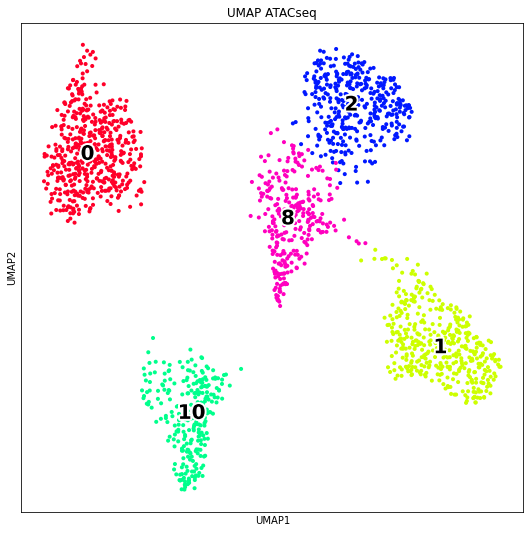

Trying to set attribute `.uns` of view, copying.


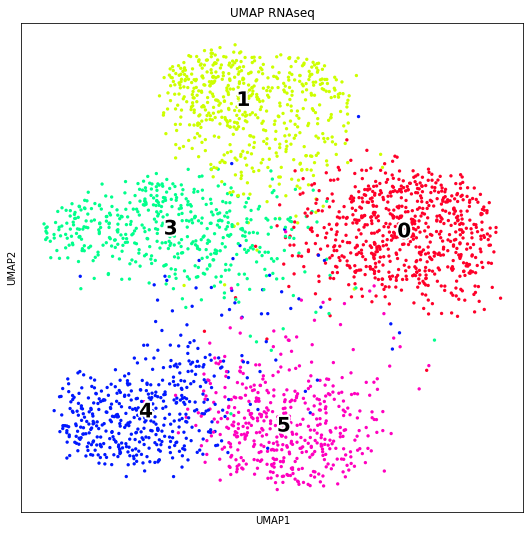

In [19]:
# Save high resolution picture
# rcParams['figure.figsize'] = 9, 9

# Rows without correspondence
# without_corr = [11, 12, 13]
# for row in without_corr:
#     atac_cis_on_org = rm_cls(atac_cis_on_org, row)


sc.pl.umap(atac_cis_on_org, color=['leiden'], legend_loc='on data', legend_fontsize=20, legend_fontoutline=4,frameon=True, title='UMAP ATACseq', palette='gist_rainbow', save='UMAP_ATAC_5k_rm_noise_final.svg')#
sc.pl.umap(rna, color=['leiden'], legend_loc='on data', legend_fontsize=20, legend_fontoutline=4,frameon=True, title='UMAP RNAseq', palette='gist_rainbow', save='UMAP_RNA_5k_rm_noise_final.svg')#



In [20]:
print(rna.shape, atac_cis_on_org.shape)


# Number of shared cells
len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))



(2692, 3724) (1826, 19598)


1360

# FW

In [24]:
# From the above we know
col_ind = col_ind_cor

In [25]:
# Taken from Darwin
import time
from collections import Counter
from sklearn.cluster import KMeans

time1 = time.time()
# Hyperparameter 1
for my_threshold in [0]:
    print(my_threshold)
#     col_ind = match_clusters4(markers_rna, markers_atac, method="count", verbose=False, threshold=my_threshold)
    
    union_markers_rna = get_union_marker_genes(markers_rna, col_ind)
    union_mrakers_atac = get_union_marker_genes(markers_atac, col_ind)
    intersect_marker_genes = (union_markers_rna & union_mrakers_atac)
    print("Intersect: ", len(intersect_marker_genes))

    # Save cells of rna and atac clusters in two seperate dictionaries
    clusters_r = dict()
    clusters_a = dict()
    atac_k_all_genes = []
    rna_k_all_genes = []

    atac_multi_cells_clusters = dict()
    rna_multi_cells_clusters = dict()  
    
   ##################################  conserved edges ##################################
    clusters_r_intersect = dict()
    clusters_a_intersect = dict()
    clusters_r_before_multi = dict()
    clusters_a_before_multi = dict()
    intersect_marker_r_a = get_shared_markers(markers_rna, markers_atac, my_threshold)
    
    # clusters of scRNA
    for rna_k, atac_k in col_ind.items():
        # aligned cluster of scATACseq
#         atac_k = col_ind[rna_k]
        print(rna_k, atac_k)   

        # marker genes in this cluster of rna
        markers_rna_k = markers_rna[str(rna_k) + "_n"].dropna().values
        cells_in_cluster_rna = get_cells_cluster(rna, rna_k)
        # DataFrame of expression matrix for each cluster
        rna_k_all_genes.append(rna[rna.obs.loc[cells_in_cluster_rna].index, :].to_df())
        # Only marker genes
        adata_rna_k = rna[rna.obs.loc[cells_in_cluster_rna].index, markers_rna_k]
        print("RNA: ", adata_rna_k.shape)

        # marker genes in this cluster of ATAC
        markers_atac_k = markers_atac[str(atac_k) + "_n"].dropna().values
        cells_in_cluster_atac = get_cells_cluster(atac_cis_on_org, atac_k)
        # DataFrame of expression matrix for each cluster
        atac_k_all_genes.append(atac_cis_on_org[atac_cis_on_org.obs.loc[cells_in_cluster_atac].index, :].to_df())
        adata_atac_k = atac_cis_on_org[atac_cis_on_org.obs.loc[cells_in_cluster_atac].index, markers_atac_k]
        print("ATAC: ", adata_atac_k.shape)

        print("------------------------before Kmeans----------------------")
        time2 = time.time()
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

        ########################################### KMeans #################################
        if adata_rna_k.shape[0] > adata_atac_k.shape[0]:
            # Perform Kmeans on RNA data using size of ATAC data
            rna_multicell_df = find_multi_cells(adata_rna_k, n_clusters=adata_atac_k.shape[0])
            rna_multi_cells_clusters[rna_k] = rna_multicell_df # Modified 
            atac_multi_cells_clusters[col_ind[rna_k]] = adata_atac_k.to_df() # Not modified

        elif adata_rna_k.shape[0] < adata_atac_k.shape[0]:
            # Perform Kmeans on ATAC data using size of RNA data
            atac_multicell_df = find_multi_cells(adata_atac_k, n_clusters=adata_rna_k.shape[0])
            atac_multi_cells_clusters[col_ind[rna_k]] = atac_multicell_df
            rna_multi_cells_clusters[rna_k] = adata_rna_k.to_df()
        
        print("------------------------after Kmeans----------------------")
        time2 = time.time()
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

        ################# Calculate logFC for each cell based on its cluster's marker genes #################
        
        
        log2fc_rna_cluster = calc_log2fc_vectors(rna_multi_cells_clusters[rna_k], rna.to_df()[intersect_marker_genes], verbose=False)
        log2fc_atac_cluster = calc_log2fc_vectors(atac_multi_cells_clusters[col_ind[rna_k]], atac_cis_on_org.to_df()[intersect_marker_genes], verbose=False)

        clusters_r[rna_k] = log2fc_rna_cluster
        clusters_a[atac_k] = log2fc_atac_cluster
        
        # Multi cells
        log2fc_rna_cluster = calc_log2fc_vectors(rna_multi_cells_clusters[rna_k], rna.to_df()[intersect_marker_r_a[rna_k]], verbose=False)
        log2fc_atac_cluster = calc_log2fc_vectors(atac_multi_cells_clusters[col_ind[rna_k]], atac_cis_on_org.to_df()[intersect_marker_r_a[rna_k]], verbose=False)

        clusters_r_intersect[rna_k] = pd.DataFrame(log2fc_rna_cluster)
        clusters_a_intersect[atac_k] = pd.DataFrame(log2fc_atac_cluster)
        print("------------------------after multicells----------------------")
        time2 = time.time()
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

    print("------------------------before similarity----------------------")  
    time2 = time.time()
    print("A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)
    ################################## Cell level similarities between RNA and ATAC  ##################################
    sim_all = dict()
    sim_all_non_scaled = dict()

    print_p = True

    # For each cluster
    for cls_i, cls_a in col_ind.items():
        expr_vect1_greater_dict = dict()
    #         cls_a = col_ind[cls_i]
        print(cls_i, cls_a)
        sim_df = pd.DataFrame()

        for cell1 in clusters_r[cls_i].index:
            expr_vect1 = clusters_r[cls_i].loc[cell1]
            # greater than 1 -> sort
            expr_vect1_greater = expr_vect1[expr_vect1 >= 1].sort_values(ascending=False)
    #         print(cell1, expr_vect1_greater)
            expr_vect1_greater_dict[cell1] = expr_vect1_greater
            if print_p:
                print('RNA')
#                 print(expr_vect1_greater)
                print_p = False       
        time2 = time.time()
        print("A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

        print_p = True
        for cell2 in clusters_a[cls_a].index:
            expr_vect2 = clusters_a[cls_a].loc[cell2]

            # Find genes of ATAC that have avg expr >= 1 which are shared and >=1  in both RNA and ATAC
            expr_vect2_greater = expr_vect2[expr_vect2 >= 1]
            for cell1, expr_vect1_greater in expr_vect1_greater_dict.items():

                # Shared genes >= 1
                shared_genes_g_1 = set(expr_vect1_greater.index).intersection(expr_vect2_greater.index)

                genes_to_rank = expr_vect2_greater.loc[shared_genes_g_1].index

                 # Find rank RNA shared similairty
                marker_list = expr_vect1_greater.index.isin(expr_vect2_greater.index)
                indecies_in_rna = np.where(marker_list)[0]
                if True: #Top 100
                    indecies_in_rna = np.asarray([i for i in indecies_in_rna if i <= 100])
                if print_p:
                    print('ATAC')
#                     print(expr_vect2_greater)
                    print("#Genes shared and greater than 1 in RNA and ATAC: ", len(shared_genes_g_1))
                    print_p = False
                    print(indecies_in_rna)


                sim_df.loc[cell1, cell2] = np.sum(np.sqrt(1 / (indecies_in_rna + 1)))
        sim_all[cls_i] = sim_df/np.max(sim_df.to_numpy()) # scale

    print("------------------------after RNA-ATAC similarity----------------------")   
    time2 = time.time()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)



    print("------------------------before similarity RNA-RNA and ATAC-ATAC ----------------------")  
    time2 = time.time()
    print("A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)   
    sim_rna_all = dict()
    sim_atac_all = dict()
    # For each cluster    
    for cls_i, cls_a in col_ind.items():
        ################################## Cell level similarities in RNA  #######################
        sim_all1, sim_all_non_scaled11 = get_similarity(cls_i, clusters_r)
        sim_rna_all[cls_i] = sim_all1
        #sim_rna_all_non_scaled.append(sim_all_non_scaled1)
        ################################## Cell level similarities in ATAC  #######################
        sim_all1, sim_all_non_scaled1 = get_similarity(col_ind[cls_i], clusters_a)
        sim_atac_all[col_ind[cls_i]] = sim_all1
        #sim_atac_all_non_scaled.append(sim_all_non_scaled1)   

    print("------------------------before FW----------------------")   
    time2 = time.time()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)        

    #3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 45, 50, 60, 70, 80, 90
    for n_neigh in [3]:
    #         if n_neigh < 30:
    #             levs = [1, 2, 3]
    #         elif n_neigh < 50:
    #             levs = [1, 2]
    #         else:
    #             levs = [1]
        levs = [2]
        for lev in levs:

            adj_rna = dict()
            adj_atac = dict()

            # Hyperparameter 2   
            lambds = [0.8] # 0.2, 0.8
            ind = 0
            fosccttm_df = pd.DataFrame(columns=['Cluster', 'Lambda', 'fracs1_sum', 'len_fracs1', 'fracs2_sum', 'len_fracs2'])
            n_runs = 1
            #             true_shared_E_list = []
            #             fracs_sum = pd.DataFrame(columns=['cluster', 'correspondence', 'sum_fracs', 'len'])

            fracs1_all = []
            fracs2_all = []
            
            for i, atac_i in col_ind.items():
            #                 atac_i = col_ind[i]
                ind, col = clusters_r[i].index, clusters_r[i].index
                vals = get_knn(clusters_r[i], n_neigh, level=lev)
                # Symmetric KNN
                vals = make_symm(vals, method='AND')
                adj_rna[i] = pd.DataFrame(vals, index=ind, columns=col)
                ind, col = clusters_a[atac_i].index, clusters_a[atac_i].index
                vals = get_knn(clusters_a[atac_i], n_neigh, level=lev)
                # Symmetric KNN
                vals = make_symm(vals, method='AND')
                adj_atac[atac_i] = pd.DataFrame(vals, index=ind, columns=col)



            #             for i in range(len(adj_rna)): 
                X = adj_rna[i].copy()
                Y = adj_atac[atac_i].copy()
                print(X.shape, Y.shape)

                X_mult_sim = np.multiply(X, sim_rna_all[i][0])
                Y_mult_sim = np.multiply(Y, sim_atac_all[atac_i][0])


                print("************************************ Cluster ", i, "************************************ ")
                for l in lambds:

                    for n_iter in range(n_runs):
                        final_P, col_ind_cells, frac, j_p, fracs_list1, fracs_list2 = run_fw(X_mult_sim.values, Y_mult_sim.values, sim_all[i], rna_multi_cells_clusters, i, 40, l) # gamma='opt' default
                        fracs1_all = fracs1_all + fracs_list1
                        fracs2_all = fracs2_all + fracs_list2


                        fosccttm_df.loc[0 if pd.isnull(fosccttm_df.index.max()) else fosccttm_df.index.max() + 1] = [int(i), l, np.sum(fracs_list1), len(fracs_list1), np.sum(fracs_list2), len(fracs_list2)]
            #                         fracs_sum.loc[0 if pd.isnull(fracs_sum.index.max()) else fracs_sum.index.max() + 1] = [i, col_ind[i], frac, len_fo]

            #                 np.save(str(i) + "_" + str(col_ind[i]) + str(n_neigh) + 'knn_marker_genes_thr_' + str(my_threshold) + '_level_' + str(lev) + "_" +  str(n_iter) +  '_fracs1.npy', fracs_list1) # save
            #                 np.save(str(i) + "_" + str(col_ind[i])  + str(n_neigh) + 'knn_marker_genes_thr_' + str(my_threshold) + '_level_' + str(lev) +  "_" + str(n_iter) +   '_fracs2.npy', fracs_list2) # save 
            #display(fosccttm_df)
            print(n_neigh, my_threshold)
            #             fosccttm_df.to_csv(str(n_neigh) + 'knn_marker_genes_thr_' + str(my_threshold) + '_level_' + str(lev) + '.csv', index=True, header=True, sep='\t')



0
167 111
88751 19598
Intersect:  94
0 2
RNA:  (703, 35)
ATAC:  (377, 18293)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0.16576886177062988


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (377, 35)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 3.83774733543396
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 3.983992099761963
1 1
RNA:  (562, 61)
ATAC:  (405, 18835)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 4.0114905834198


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (405, 61)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 9.661751985549927
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 9.83128309249878
3 8


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


RNA:  (491, 16)
ATAC:  (286, 17258)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 9.852460384368896
After combining multi-cells:  (286, 16)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 11.967059135437012
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 12.081983089447021
4 10
RNA:  (476, 24)
ATAC:  (259, 18924)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 12.104406356811523


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (259, 24)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 14.266056537628174
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 14.39110279083252
5 0
RNA:  (460, 25)
ATAC:  (499, 17678)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 14.421774864196777


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (460, 17678)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 209.56423497200012
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 209.71477580070496
------------------------before similarity----------------------
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 209.71480512619019
0 2
RNA
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 209.9324176311493
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  9
[ 0  3  4  5  6  8  9 12 13]
1 1
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 416.4460082054138
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  5
[ 4  5  7  8 16]
3 8
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 659.9107978343964
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  4
[1 2 3 5]
4 10
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 775.0912489891052
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  3
[1 4 5]
5 0
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 874.5663056373596
ATAC
#Genes shared and greater than 1 in RN

/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(377, 377) (377, 377)
************************************ Cluster  0 ************************************ 
Inside calc_foscttm: 


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
TGGAATTTTCTC,0.000613,0.000128,0.000056,0.000068,0.000077,0.000046,0.000036,0.000001,0.000076,0.000014,0.000049,0.000009,0.000006,0.000008,0.000032,...,6.547270e-07,2.898708e-07,2.271336e-06,1.043957e-06,4.141484e-07,0.000003,0.000002,4.970951e-07,1.072704e-07,1.489296e-07,0.000005,2.660865e-07,0.000014,0.000075,0.000041
CCAACAAACGCG,0.000619,0.000109,0.000061,0.000081,0.000066,0.000047,0.000022,0.000002,0.000067,0.000018,0.000049,0.000011,0.000006,0.000015,0.000021,...,8.265480e-07,2.619727e-07,1.276636e-06,7.546524e-07,3.339781e-07,0.000002,0.000003,3.371309e-07,1.194259e-07,1.870704e-07,0.000007,2.183625e-07,0.000012,0.000074,0.000042
ACAGTCTACATG,0.000613,0.000149,0.000062,0.000068,0.000091,0.000043,0.000051,0.000002,0.000083,0.000012,0.000053,0.000008,0.000007,0.000004,0.000043,...,6.858656e-07,1.951005e-07,1.556625e-06,8.342648e-07,5.984066e-07,0.000002,0.000002,6.923029e-07,1.050989e-07,1.407703e-07,0.000004,3.058193e-07,0.000017,0.000057,0.000041
GCAACCTGAACA,0.000604,0.000155,0.000062,0.000061,0.000090,0.000051,0.000045,0.000002,0.000078,0.000012,0.000048,0.000009,0.000006,0.000005,0.000036,...,8.953198e-07,1.236426e-07,4.921421e-07,4.981123e-07,5.289752e-07,0.000002,0.000002,5.804031e-07,9.440198e-08,1.434331e-07,0.000005,3.213013e-07,0.000016,0.000082,0.000045
CAACAGCTCTCA,0.000602,0.000132,0.000053,0.000057,0.000084,0.000044,0.000043,0.000001,0.000078,0.000012,0.000048,0.000007,0.000006,0.000008,0.000036,...,1.155243e-06,2.400250e-07,1.637110e-06,8.343808e-07,4.914160e-07,0.000002,0.000002,5.840492e-07,9.401571e-08,1.304849e-07,0.000004,2.715695e-07,0.000015,0.000063,0.000043


295
Check:  703 377 2
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
ATGTTGTCCTGC,0.000634,0.000101,0.000056,0.000080,0.000062,0.000040,0.000026,0.000002,0.000091,0.000015,0.000051,0.000009,0.000004,0.000010,0.000023,...,2.023148e-07,4.461556e-07,0.000004,0.000002,3.361360e-07,0.000003,0.000002,4.332844e-07,9.595198e-08,1.683147e-07,0.000006,2.102850e-07,0.000014,0.000062,0.000035
CCAAGAATTAAA,0.000619,0.000108,0.000051,0.000077,0.000064,0.000035,0.000033,0.000001,0.000074,0.000016,0.000053,0.000009,0.000007,0.000007,0.000038,...,6.913100e-07,3.947544e-07,0.000004,0.000001,3.271398e-07,0.000003,0.000004,4.760396e-07,1.530522e-07,1.498305e-07,0.000005,2.050073e-07,0.000011,0.000058,0.000036
CTGTCTAATTGC,0.000634,0.000123,0.000044,0.000063,0.000070,0.000038,0.000036,0.000001,0.000087,0.000013,0.000046,0.000007,0.000007,0.000005,0.000040,...,4.241861e-07,4.057746e-07,0.000004,0.000002,3.422721e-07,0.000004,0.000004,4.962343e-07,1.450945e-07,1.195816e-07,0.000004,2.370081e-07,0.000013,0.000072,0.000035
CCGCCTGGTCAT,0.000614,0.000125,0.000051,0.000064,0.000080,0.000047,0.000037,0.000001,0.000070,0.000013,0.000047,0.000008,0.000006,0.000009,0.000032,...,5.996707e-07,3.783117e-07,0.000003,0.000001,4.311653e-07,0.000003,0.000002,5.386298e-07,1.027595e-07,1.339175e-07,0.000004,2.692211e-07,0.000012,0.000073,0.000040
CTTGCTGGATAG,0.000623,0.000094,0.000062,0.000095,0.000055,0.000036,0.000023,0.000002,0.000081,0.000016,0.000055,0.000011,0.000004,0.000010,0.000019,...,3.967346e-07,4.655628e-07,0.000004,0.000002,3.491676e-07,0.000003,0.000002,4.764541e-07,9.556685e-08,1.948827e-07,0.000007,1.997605e-07,0.000013,0.000050,0.000036


703 377 320 0.09191285767372724 324 0.23681011169900062 0.16436148468636394


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(405, 405) (405, 405)
************************************ Cluster  1 ************************************ 
Inside calc_foscttm: 


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
TGGAATTTTCTC,0.000613,0.000128,0.000056,0.000068,0.000077,0.000046,0.000036,0.000001,0.000076,0.000014,0.000049,0.000009,0.000006,0.000008,0.000032,...,6.547270e-07,2.898708e-07,2.271336e-06,1.043957e-06,4.141484e-07,0.000003,0.000002,4.970951e-07,1.072704e-07,1.489296e-07,0.000005,2.660865e-07,0.000014,0.000075,0.000041
CCAACAAACGCG,0.000619,0.000109,0.000061,0.000081,0.000066,0.000047,0.000022,0.000002,0.000067,0.000018,0.000049,0.000011,0.000006,0.000015,0.000021,...,8.265480e-07,2.619727e-07,1.276636e-06,7.546524e-07,3.339781e-07,0.000002,0.000003,3.371309e-07,1.194259e-07,1.870704e-07,0.000007,2.183625e-07,0.000012,0.000074,0.000042
ACAGTCTACATG,0.000613,0.000149,0.000062,0.000068,0.000091,0.000043,0.000051,0.000002,0.000083,0.000012,0.000053,0.000008,0.000007,0.000004,0.000043,...,6.858656e-07,1.951005e-07,1.556625e-06,8.342648e-07,5.984066e-07,0.000002,0.000002,6.923029e-07,1.050989e-07,1.407703e-07,0.000004,3.058193e-07,0.000017,0.000057,0.000041
GCAACCTGAACA,0.000604,0.000155,0.000062,0.000061,0.000090,0.000051,0.000045,0.000002,0.000078,0.000012,0.000048,0.000009,0.000006,0.000005,0.000036,...,8.953198e-07,1.236426e-07,4.921421e-07,4.981123e-07,5.289752e-07,0.000002,0.000002,5.804031e-07,9.440198e-08,1.434331e-07,0.000005,3.213013e-07,0.000016,0.000082,0.000045
CAACAGCTCTCA,0.000602,0.000132,0.000053,0.000057,0.000084,0.000044,0.000043,0.000001,0.000078,0.000012,0.000048,0.000007,0.000006,0.000008,0.000036,...,1.155243e-06,2.400250e-07,1.637110e-06,8.343808e-07,4.914160e-07,0.000002,0.000002,5.840492e-07,9.401571e-08,1.304849e-07,0.000004,2.715695e-07,0.000015,0.000063,0.000043


341
Check:  562 405 1
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
GCACCGCTATAA,0.000657,0.000141,0.000049,0.000072,0.000077,0.000034,0.000048,0.000001,0.000071,0.000020,0.000054,0.000009,0.000013,0.000003,0.000067,...,3.479292e-07,1.841537e-07,1.418854e-06,7.286458e-07,3.746051e-07,0.000004,0.000009,4.427517e-07,2.712167e-07,1.226361e-07,0.000003,2.213980e-07,0.000013,0.000067,0.000033
GAGCCGACCGGA,0.000670,0.000151,0.000050,0.000071,0.000069,0.000045,0.000032,0.000001,0.000073,0.000018,0.000041,0.000011,0.000012,0.000006,0.000045,...,4.512388e-07,1.513471e-07,7.144898e-07,5.444360e-07,3.268463e-07,0.000003,0.000008,3.486042e-07,2.467160e-07,1.362668e-07,0.000004,2.497228e-07,0.000013,0.000097,0.000037
CCGGTGCATGTA,0.000620,0.000131,0.000043,0.000068,0.000071,0.000036,0.000041,0.000001,0.000043,0.000019,0.000050,0.000009,0.000012,0.000005,0.000058,...,1.292128e-06,2.393896e-07,1.887247e-06,7.827287e-07,3.264870e-07,0.000004,0.000009,4.642559e-07,2.644413e-07,1.197067e-07,0.000003,2.132815e-07,0.000007,0.000067,0.000038
TACCTATGATGA,0.000646,0.000134,0.000047,0.000074,0.000071,0.000037,0.000040,0.000001,0.000055,0.000021,0.000052,0.000010,0.000013,0.000005,0.000060,...,6.395877e-07,2.007118e-07,1.368507e-06,6.737832e-07,3.018527e-07,0.000004,0.000009,3.684962e-07,2.785574e-07,1.318022e-07,0.000004,2.107668e-07,0.000009,0.000076,0.000036
GCTTCGACTTGT,0.000649,0.000130,0.000053,0.000088,0.000064,0.000033,0.000037,0.000002,0.000056,0.000021,0.000053,0.000011,0.000013,0.000005,0.000055,...,7.751177e-07,2.027525e-07,1.439639e-06,7.262356e-07,3.456454e-07,0.000004,0.000009,4.282676e-07,2.778485e-07,1.554872e-07,0.000005,1.994816e-07,0.000010,0.000061,0.000035


562 405 356 0.08307445960108394 382 0.27085944862710987 0.1769669541140969


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(286, 286) (286, 286)
************************************ Cluster  3 ************************************ 
Inside calc_foscttm: 


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
TGGAATTTTCTC,0.000613,0.000128,0.000056,0.000068,0.000077,0.000046,0.000036,0.000001,0.000076,0.000014,0.000049,0.000009,0.000006,0.000008,0.000032,...,6.547270e-07,2.898708e-07,2.271336e-06,1.043957e-06,4.141484e-07,0.000003,0.000002,4.970951e-07,1.072704e-07,1.489296e-07,0.000005,2.660865e-07,0.000014,0.000075,0.000041
CCAACAAACGCG,0.000619,0.000109,0.000061,0.000081,0.000066,0.000047,0.000022,0.000002,0.000067,0.000018,0.000049,0.000011,0.000006,0.000015,0.000021,...,8.265480e-07,2.619727e-07,1.276636e-06,7.546524e-07,3.339781e-07,0.000002,0.000003,3.371309e-07,1.194259e-07,1.870704e-07,0.000007,2.183625e-07,0.000012,0.000074,0.000042
ACAGTCTACATG,0.000613,0.000149,0.000062,0.000068,0.000091,0.000043,0.000051,0.000002,0.000083,0.000012,0.000053,0.000008,0.000007,0.000004,0.000043,...,6.858656e-07,1.951005e-07,1.556625e-06,8.342648e-07,5.984066e-07,0.000002,0.000002,6.923029e-07,1.050989e-07,1.407703e-07,0.000004,3.058193e-07,0.000017,0.000057,0.000041
GCAACCTGAACA,0.000604,0.000155,0.000062,0.000061,0.000090,0.000051,0.000045,0.000002,0.000078,0.000012,0.000048,0.000009,0.000006,0.000005,0.000036,...,8.953198e-07,1.236426e-07,4.921421e-07,4.981123e-07,5.289752e-07,0.000002,0.000002,5.804031e-07,9.440198e-08,1.434331e-07,0.000005,3.213013e-07,0.000016,0.000082,0.000045
CAACAGCTCTCA,0.000602,0.000132,0.000053,0.000057,0.000084,0.000044,0.000043,0.000001,0.000078,0.000012,0.000048,0.000007,0.000006,0.000008,0.000036,...,1.155243e-06,2.400250e-07,1.637110e-06,8.343808e-07,4.914160e-07,0.000002,0.000002,5.840492e-07,9.401571e-08,1.304849e-07,0.000004,2.715695e-07,0.000015,0.000063,0.000043


199
Check:  491 286 8
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
TGGAATTTTCTC,0.000613,0.000128,0.000056,0.000068,0.000077,0.000046,0.000036,0.000001,0.000076,0.000014,0.000049,0.000009,0.000006,0.000008,0.000032,...,6.547270e-07,2.898708e-07,2.271336e-06,1.043957e-06,4.141484e-07,0.000003,0.000002,4.970951e-07,1.072704e-07,1.489296e-07,0.000005,2.660865e-07,0.000014,0.000075,0.000041
ACAGTCTACATG,0.000613,0.000149,0.000062,0.000068,0.000091,0.000043,0.000051,0.000002,0.000083,0.000012,0.000053,0.000008,0.000007,0.000004,0.000043,...,6.858656e-07,1.951005e-07,1.556625e-06,8.342648e-07,5.984066e-07,0.000002,0.000002,6.923029e-07,1.050989e-07,1.407703e-07,0.000004,3.058193e-07,0.000017,0.000057,0.000041
GCAACCTGAACA,0.000604,0.000155,0.000062,0.000061,0.000090,0.000051,0.000045,0.000002,0.000078,0.000012,0.000048,0.000009,0.000006,0.000005,0.000036,...,8.953198e-07,1.236426e-07,4.921421e-07,4.981123e-07,5.289752e-07,0.000002,0.000002,5.804031e-07,9.440198e-08,1.434331e-07,0.000005,3.213013e-07,0.000016,0.000082,0.000045
CAACAGCTCTCA,0.000602,0.000132,0.000053,0.000057,0.000084,0.000044,0.000043,0.000001,0.000078,0.000012,0.000048,0.000007,0.000006,0.000008,0.000036,...,1.155243e-06,2.400250e-07,1.637110e-06,8.343808e-07,4.914160e-07,0.000002,0.000002,5.840492e-07,9.401571e-08,1.304849e-07,0.000004,2.715695e-07,0.000015,0.000063,0.000043
ATCGGGTACCAA,0.000592,0.000131,0.000064,0.000074,0.000073,0.000041,0.000038,0.000002,0.000084,0.000014,0.000056,0.000010,0.000005,0.000005,0.000034,...,1.036108e-06,1.749834e-07,1.244321e-06,7.694341e-07,3.999413e-07,0.000002,0.000002,5.008471e-07,9.807420e-08,1.684321e-07,0.000006,2.627920e-07,0.000015,0.000071,0.000043


491 286 265 0.10570244630950128 222 0.19651663992759885 0.15110954311855007


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(259, 259) (259, 259)
************************************ Cluster  4 ************************************ 
Inside calc_foscttm: 


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
TGGAATTTTCTC,0.000613,0.000128,0.000056,0.000068,0.000077,0.000046,0.000036,0.000001,0.000076,0.000014,0.000049,0.000009,0.000006,0.000008,0.000032,...,6.547270e-07,2.898708e-07,2.271336e-06,1.043957e-06,4.141484e-07,0.000003,0.000002,4.970951e-07,1.072704e-07,1.489296e-07,0.000005,2.660865e-07,0.000014,0.000075,0.000041
CCAACAAACGCG,0.000619,0.000109,0.000061,0.000081,0.000066,0.000047,0.000022,0.000002,0.000067,0.000018,0.000049,0.000011,0.000006,0.000015,0.000021,...,8.265480e-07,2.619727e-07,1.276636e-06,7.546524e-07,3.339781e-07,0.000002,0.000003,3.371309e-07,1.194259e-07,1.870704e-07,0.000007,2.183625e-07,0.000012,0.000074,0.000042
ACAGTCTACATG,0.000613,0.000149,0.000062,0.000068,0.000091,0.000043,0.000051,0.000002,0.000083,0.000012,0.000053,0.000008,0.000007,0.000004,0.000043,...,6.858656e-07,1.951005e-07,1.556625e-06,8.342648e-07,5.984066e-07,0.000002,0.000002,6.923029e-07,1.050989e-07,1.407703e-07,0.000004,3.058193e-07,0.000017,0.000057,0.000041
GCAACCTGAACA,0.000604,0.000155,0.000062,0.000061,0.000090,0.000051,0.000045,0.000002,0.000078,0.000012,0.000048,0.000009,0.000006,0.000005,0.000036,...,8.953198e-07,1.236426e-07,4.921421e-07,4.981123e-07,5.289752e-07,0.000002,0.000002,5.804031e-07,9.440198e-08,1.434331e-07,0.000005,3.213013e-07,0.000016,0.000082,0.000045
CAACAGCTCTCA,0.000602,0.000132,0.000053,0.000057,0.000084,0.000044,0.000043,0.000001,0.000078,0.000012,0.000048,0.000007,0.000006,0.000008,0.000036,...,1.155243e-06,2.400250e-07,1.637110e-06,8.343808e-07,4.914160e-07,0.000002,0.000002,5.840492e-07,9.401571e-08,1.304849e-07,0.000004,2.715695e-07,0.000015,0.000063,0.000043


187
Check:  476 259 10
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
CGTTTCCTGTAC,0.000573,0.000100,0.000052,0.000064,0.000057,0.000039,0.000021,0.000001,0.000069,0.000015,0.000045,0.000009,0.000004,0.000015,0.000016,...,0.000002,2.266120e-07,9.022357e-07,6.223047e-07,3.203528e-07,0.000002,1.425202e-06,4.286652e-07,8.595080e-08,1.683808e-07,0.000006,1.911121e-07,0.000012,0.000056,0.000047
TGTTTTTAGAAT,0.000551,0.000111,0.000046,0.000061,0.000052,0.000033,0.000024,0.000001,0.000066,0.000011,0.000044,0.000008,0.000004,0.000007,0.000020,...,0.000003,2.824656e-07,2.374260e-06,1.040254e-06,2.980740e-07,0.000003,1.718552e-06,5.567525e-07,9.403494e-08,1.468725e-07,0.000005,2.127267e-07,0.000011,0.000059,0.000047
ATCCACCATGGC,0.000564,0.000103,0.000056,0.000069,0.000057,0.000037,0.000023,0.000002,0.000071,0.000014,0.000048,0.000009,0.000003,0.000012,0.000016,...,0.000002,2.139778e-07,9.969024e-07,6.662233e-07,3.412133e-07,0.000002,9.446654e-07,4.742107e-07,7.517387e-08,1.768097e-07,0.000006,2.007822e-07,0.000013,0.000053,0.000047
AGTCTCTGCAAC,0.000550,0.000121,0.000053,0.000066,0.000052,0.000039,0.000021,0.000001,0.000058,0.000012,0.000043,0.000009,0.000004,0.000009,0.000013,...,0.000003,1.688616e-07,8.518642e-07,5.761165e-07,3.142328e-07,0.000002,1.610144e-06,5.133809e-07,9.424409e-08,1.679768e-07,0.000006,2.341123e-07,0.000011,0.000071,0.000051
GGGTACGGCCGC,0.000564,0.000105,0.000047,0.000058,0.000058,0.000045,0.000017,0.000001,0.000053,0.000014,0.000039,0.000009,0.000004,0.000016,0.000010,...,0.000003,2.426628e-07,9.553230e-07,5.833477e-07,3.045209e-07,0.000002,1.476363e-06,4.247458e-07,8.672296e-08,1.589481e-07,0.000005,2.099565e-07,0.000009,0.000069,0.000050


476 259 204 0.06922494006892983 208 0.1553022103467309 0.11226357520783037


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(460, 460) (460, 460)
************************************ Cluster  5 ************************************ 
Inside calc_foscttm: 


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
TGGAATTTTCTC,0.000613,0.000128,0.000056,0.000068,0.000077,0.000046,0.000036,0.000001,0.000076,0.000014,0.000049,0.000009,0.000006,0.000008,0.000032,...,6.547270e-07,2.898708e-07,2.271336e-06,1.043957e-06,4.141484e-07,0.000003,0.000002,4.970951e-07,1.072704e-07,1.489296e-07,0.000005,2.660865e-07,0.000014,0.000075,0.000041
CCAACAAACGCG,0.000619,0.000109,0.000061,0.000081,0.000066,0.000047,0.000022,0.000002,0.000067,0.000018,0.000049,0.000011,0.000006,0.000015,0.000021,...,8.265480e-07,2.619727e-07,1.276636e-06,7.546524e-07,3.339781e-07,0.000002,0.000003,3.371309e-07,1.194259e-07,1.870704e-07,0.000007,2.183625e-07,0.000012,0.000074,0.000042
ACAGTCTACATG,0.000613,0.000149,0.000062,0.000068,0.000091,0.000043,0.000051,0.000002,0.000083,0.000012,0.000053,0.000008,0.000007,0.000004,0.000043,...,6.858656e-07,1.951005e-07,1.556625e-06,8.342648e-07,5.984066e-07,0.000002,0.000002,6.923029e-07,1.050989e-07,1.407703e-07,0.000004,3.058193e-07,0.000017,0.000057,0.000041
GCAACCTGAACA,0.000604,0.000155,0.000062,0.000061,0.000090,0.000051,0.000045,0.000002,0.000078,0.000012,0.000048,0.000009,0.000006,0.000005,0.000036,...,8.953198e-07,1.236426e-07,4.921421e-07,4.981123e-07,5.289752e-07,0.000002,0.000002,5.804031e-07,9.440198e-08,1.434331e-07,0.000005,3.213013e-07,0.000016,0.000082,0.000045
CAACAGCTCTCA,0.000602,0.000132,0.000053,0.000057,0.000084,0.000044,0.000043,0.000001,0.000078,0.000012,0.000048,0.000007,0.000006,0.000008,0.000036,...,1.155243e-06,2.400250e-07,1.637110e-06,8.343808e-07,4.914160e-07,0.000002,0.000002,5.840492e-07,9.401571e-08,1.304849e-07,0.000004,2.715695e-07,0.000015,0.000063,0.000043


198
Check:  460 499 0
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,1110002E22Rik,1110002J07Rik,...,n-R5s72,n-R5s74,n-R5s77,n-R5s79,n-R5s80,n-R5s82,n-R5s85,n-R5s86,n-R5s87,n-R5s94,n-R5s95,n-R5s96,n-R5s98,n-TSaga9,n-TStga1
CCAACAAACGCG,0.000619,0.000109,0.000061,0.000081,0.000066,0.000047,0.000022,0.000002,0.000067,0.000018,0.000049,0.000011,0.000006,0.000015,0.000021,...,8.265480e-07,2.619727e-07,1.276636e-06,7.546524e-07,3.339781e-07,0.000002,3.002473e-06,3.371309e-07,1.194259e-07,1.870704e-07,0.000007,2.183625e-07,0.000012,0.000074,0.000042
GCGATAATAGCC,0.000599,0.000106,0.000060,0.000073,0.000062,0.000047,0.000019,0.000002,0.000077,0.000016,0.000047,0.000010,0.000003,0.000015,0.000012,...,1.320459e-06,2.549222e-07,1.219607e-06,7.674503e-07,3.190839e-07,0.000002,9.279362e-07,3.567701e-07,7.033812e-08,1.857857e-07,0.000007,2.215207e-07,0.000013,0.000075,0.000045
GCGAGCGGATTA,0.000622,0.000098,0.000069,0.000084,0.000073,0.000051,0.000023,0.000002,0.000074,0.000020,0.000054,0.000012,0.000004,0.000019,0.000017,...,4.121299e-07,2.496950e-07,6.648125e-07,6.126918e-07,3.806776e-07,0.000002,1.220146e-06,2.913427e-07,7.489551e-08,2.083272e-07,0.000008,2.131791e-07,0.000014,0.000067,0.000041
TAAAATCCTCTA,0.000609,0.000106,0.000066,0.000081,0.000069,0.000051,0.000022,0.000002,0.000067,0.000019,0.000051,0.000012,0.000004,0.000017,0.000016,...,9.081707e-07,2.218869e-07,5.595613e-07,5.483893e-07,3.596366e-07,0.000002,1.670364e-06,3.214493e-07,8.799499e-08,2.008326e-07,0.000007,2.237613e-07,0.000012,0.000073,0.000044
GGTTGAATGTCG,0.000630,0.000090,0.000052,0.000067,0.000068,0.000046,0.000022,0.000001,0.000083,0.000018,0.000047,0.000009,0.000004,0.000018,0.000022,...,6.475982e-07,3.586248e-07,2.002629e-06,1.002133e-06,3.106828e-07,0.000002,2.035777e-06,2.918908e-07,9.254627e-08,1.653573e-07,0.000006,1.814013e-07,0.000013,0.000063,0.000039


460 499 215 0.10731061620849283 224 0.17057240704500978 0.1389415116267513
3 0


In [70]:
fosccttm_df

,Cluster,Lambda,fracs1_sum,len_fracs1,fracs2_sum,len_fracs2
0,0.0,0.8,75166.0,320.0,137396.940476,324.0
1,1.0,0.8,82420.0,356.0,185104.706494,382.0
2,3.0,0.8,72975.0,265.0,76008.003846,222.0
3,4.0,0.8,35666.0,204.0,52213.064286,208.0
4,5.0,0.8,61130.0,215.0,65310.000000,224.0


In [26]:
print(fosccttm_df['len_fracs1'].sum(), fosccttm_df['len_fracs2'].sum())

1360.0 1360.0


In [27]:
# X on Y
# (fosccttm_df['fracs1_sum'].sum() / (fosccttm_df['len_fracs1'].sum() - 1)) / fosccttm_df['len_fracs1'].sum()
fosccttm_df['fracs1_sum'].sum() / (fosccttm_df['len_fracs1'].sum() * (len(atac_cis_on_org) - 1))

0.13464914047810905

In [28]:
# Y on X
# (fosccttm_df['fracs2_sum'].sum() / (fosccttm_df['len_fracs2'].sum() - 1)) / fosccttm_df['len_fracs2'].sum()
fosccttm_df['fracs2_sum'].sum() / (fosccttm_df['len_fracs2'].sum() * (len(rna) - 1))

0.14677381013298532

<span class="mark">executed in 25m 13s, finished 15:50:01 2021-06-17</span>

In [31]:
print(np.max(fracs1_all), np.max(fracs2_all))
print(len(atac_cis_on_org), len(rna))

1757.0 2685.3333333333335
1826 2692


In [32]:
fracs1_all = [i / (len(atac_cis_on_org) - 1) for i in fracs1_all]
fracs2_all = [i / (len(rna) - 1) for i in fracs2_all]

In [33]:
# Save fracs_all1 and fracs_all2

print(len(fracs1_all), len(fracs2_all))

import pickle
out_dir = "/home/ejafari/alignment/downstream/notebooks/SNAREseq_Mus/rm_noise/5k/FW_res/"

with open(out_dir + 'fracs1_same_size.pickle', 'wb') as handle:
    pickle.dump(fracs1_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(out_dir + 'fracs2_same_size.pickle', 'wb') as handle:
    pickle.dump(fracs2_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

1360 1360


# Files required for other alignment methods

/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


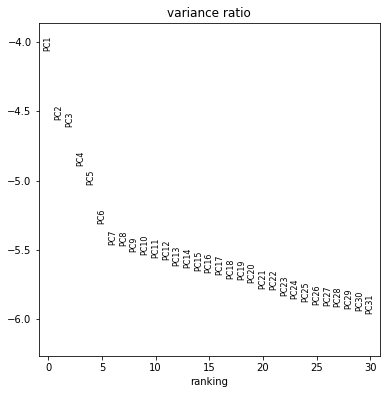

In [85]:
# Find out how many PCAs can represent the data the best
sc.tl.pca(rna, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna, log=True)

In [86]:
out_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/5k/baseline/"
from sklearn.decomposition import PCA
pca = PCA(n_components=22)
principalComponents_rna = pca.fit_transform(rna.to_df().values)

np.save(out_dir + 'rna_22D_pca_1360.npy', principalComponents_rna) # save

<span class="mark">After removing the noise using our pipeline, we follow preprocessing steps of MMD-MA and SCOT to prepare their input files.</span>

In [87]:
# Read full ATAC (RAW)
ATAC_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/5k/"
atac_raw = sc.read(ATAC_dir + 'scATACseq.csv').to_df()
print(atac_raw.shape)

# Remove the cells that we labeld them as noise in the previous sections
atac_raw = atac_raw[atac_cis_on_org.obs.index]
print(atac_raw.shape)

# Save ATAC file to preprocess and reduce the dimensionality of the data using MMD-MA script on the Hulk
atac_raw.to_csv(out_dir + 'ATAC_raw_1360.csv', index=True, header=True)

(229429, 5081)
(229429, 1826)


In [ ]:
# Move to the Hulk and run MMDMA's script on it.
scp ejafari@ampere.luddy.indiana.edu:/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/5k/baseline/ATAC_raw_1360.csv .

In [89]:
# Bring the reduced size data back 
# scp Mus_5k_1360_chromatin_reduced_SCOT.tsv ejafari@ampere.luddy.indiana.edu:/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/5k/baseline 
# scp mmdma_prep_atac.R ejafari@ampere.luddy.indiana.edu:/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/5k/baseline/

## Similarity matrix

In [14]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

rna_feat = rna.to_df()
input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/5k/baseline/"
atac_feat = pd.read_csv(input_dir + "Mus_5k_1360_chromatin_reduced_SCOT.tsv", index_col=0, delimiter='\t')

rna_mat = cosine_similarity(rna_feat, rna_feat)
atac_mat = cosine_similarity(atac_feat, atac_feat)

print("Dimensions of input datasets are: ", "X= ", rna_feat.shape, rna_mat.shape, " y= ", atac_feat.shape, atac_mat.shape)


# Save atac_mat and rna_mat as npy
np.save(input_dir + "ATAC_1360_mat.npy", atac_mat)
np.save(input_dir + "RNA_1360_mat.npy", rna_mat)




Dimensions of input datasets are:  X=  (2692, 3724) (2692, 2692)  y=  (1826, 25) (1826, 1826)


In [15]:
import pickle
out_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/5k/baseline/FW_denoise/"

# Save RNA indecies and its markers
with open(out_dir + 'RNA_index_1360.pickle', 'wb') as handle:
    pickle.dump(rna.obs.index, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(out_dir + 'markers_RNA.pickle', 'wb') as handle:
#     pickle.dump(markers_rna, handle, protocol=pickle.HIGHEST_PROTOCOL)    


# Save ATAC indecies and its markers
with open(out_dir + 'ATAC_index_1360.pickle', 'wb') as handle:
    pickle.dump(atac_cis_on_org.obs.index, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(out_dir + 'markers_ATAC.pickle', 'wb') as handle:
#     pickle.dump(markers_atac, handle, protocol=pickle.HIGHEST_PROTOCOL)  